# Klasifikasi text menggunakan algoritma naive bayes
---

Menyelesaikan kasus analisis sentimen pilkada DKI 2017

Langkah-langkah penyelesaian meliputi:

1. Data Acquisition
2. Text Preprocessing
    - Case folding
    - Remove sentence
    - Filtering
    - Stopword
    - Stemming
3. Feature Engineering
    - Featrure Extraction
    - Feature Selection
4. Modelling
5. Evaluasi
6. Kesimpulan

In [629]:
import pandas as pd
import seaborn as sns
import re, unicodedata
import swifter
import category_encoders as ce
import numpy as np

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import TfidfVectorizer


## 01 Data Acquisition

Data terdiri dari 3 dataset:

1. Dataset tweet sentiment pilkada DKI 2017 https://github.com/rizalespe/Dataset-Sentimen-Analisis-Bahasa-Indonesia/blob/master/dataset_tweet_sentiment_pilkada_DKI_2017.csv
2. Dataset normalisasi kata https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/key_norm.csv
3. Dataset stopword https://github.com/rizalespe/Dataset-Sentimen-Analisis-Bahasa-Indonesia/blob/master/stopword_tweet_pilkada_DKI_2017.csv

In [630]:
# load dataset
data = pd.read_csv('dataset_tweet_sentiment_pilkada_DKI_2017.csv')
key_norm = pd.read_csv('key_norm.csv')
stopwords_pilkada = pd.read_csv('stopword_tweet_pilkada_DKI_2017.csv')
data.head()


,Id,Sentiment,Pasangan Calon,Text Tweet
0,1,negative,Agus-Sylvi,Banyak akun kloning seolah2 pendukung #agussil...
1,2,negative,Agus-Sylvi,#agussilvy bicara apa kasihan yaa...lap itu ai...
2,3,negative,Agus-Sylvi,Kalau aku sih gak nunggu hasil akhir QC tp lag...
3,4,negative,Agus-Sylvi,Kasian oh kasian dengan peluru 1milyar untuk t...
4,5,negative,Agus-Sylvi,Maaf ya pendukung #AgusSilvy..hayo dukung #Ani...


<AxesSubplot:xlabel='Sentiment', ylabel='count'>

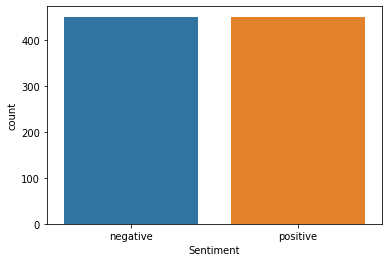

In [631]:
sns.countplot(data=data, x='Sentiment')

In [632]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Id              900 non-null    int64 
 1   Sentiment       900 non-null    object
 2   Pasangan Calon  900 non-null    object
 3   Text Tweet      900 non-null    object
dtypes: int64(1), object(3)
memory usage: 28.2+ KB


In [633]:
data['Sentiment'].unique()

array(['negative', 'positive'], dtype=object)

Penjelasan label:

- 0 : Sentiment negative
- 1 : Sentiment positive

In [634]:
mapping = [{
    'col': 'Sentiment',
    'mapping': pd.Series(data={'negative': 0, 'positive': 1}),
    'data_type': object
}]

encoder = ce.OrdinalEncoder(cols=['Sentiment'], mapping=mapping)

data = encoder.fit_transform(data)
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Id              900 non-null    int64 
 1   Sentiment       900 non-null    int32 
 2   Pasangan Calon  900 non-null    object
 3   Text Tweet      900 non-null    object
dtypes: int32(1), int64(1), object(2)
memory usage: 24.7+ KB


In [635]:
data.head()


,Id,Sentiment,Pasangan Calon,Text Tweet
0,1,0,Agus-Sylvi,Banyak akun kloning seolah2 pendukung #agussil...
1,2,0,Agus-Sylvi,#agussilvy bicara apa kasihan yaa...lap itu ai...
2,3,0,Agus-Sylvi,Kalau aku sih gak nunggu hasil akhir QC tp lag...
3,4,0,Agus-Sylvi,Kasian oh kasian dengan peluru 1milyar untuk t...
4,5,0,Agus-Sylvi,Maaf ya pendukung #AgusSilvy..hayo dukung #Ani...


## 02 Text Preprocessing

- Case folding
    - Membuat kalimat menjadi kecil serta menghilangkan karakter maupun angka yang dianggap tidak penting
- Remove sentence
    - Menghilangkan kata-kata yang memiliki 1 huruf dan 2 huruf yang sama berada diawal dan diakhir kata
- Text normalisasi
    - Menormalisasikan kata yang typo
- Remove Stopword
    - Menghilangkan kata-kata yang dianggap tidak penting, seperti kata penghubung
- Stemming
    - Membuat kata-kata menjadi kata dasar

In [636]:
class text_preprocessing:
    def __init__(self, more_stopword=['']):
        self.more_stopword = more_stopword

    def casefolding(self, text):
        text = text.lower()
        text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        text = re.sub(r'https?://\S+|www\.\S+', '', text)
        text = re.sub(r'[-+]?[0-9]+', '', text)
        text = re.sub(r'[^\w\s]', '', text)
        text = text.strip()
        return text
    
    def removeSentence(self, text):
        word = text.split()
        wordCount = len(word)
        if (wordCount <= 1):
            text = ''
        
        for kata in word:
            if len(kata) > 1:
                if kata[0] == kata[1] or kata[-1] == kata[-2]:
                    text = ''

        return text

    def text_normalize(self, text):
        text = ' '.join([key_norm[key_norm['singkat'] == word]['hasil'].values[0] if (
            key_norm['singkat'] == word).any() else word for word in text.split()])
        text = str.lower(text)
        return text

    def remove_stop_words(self, text):
        stopwords = stopwords_pilkada + self.more_stopword
        clean_words = []
        text = text.split()
        for word in text:
            if word not in stopwords:
                clean_words.append(word)
        return " ".join(clean_words)

    def stemming(self, text):
        factory = StemmerFactory()
        stemmer = factory.create_stemmer()
        text = stemmer.stem(text)
        return text

    def process(self, text):
        text = self.casefolding(text)
        text = self.removeSentence(text)
        text = self.text_normalize(text)
        text = self.remove_stop_words(text)
        text = self.stemming(text)
        return text


In [637]:
preprocessing = text_preprocessing()


### Text Preprocessing Pipeline

In [638]:
%%time
data['clean text'] = data['Text Tweet'].swifter.apply(preprocessing.process)


Pandas Apply:   0%|          | 0/900 [00:00<?, ?it/s]

CPU times: total: 7min 34s
Wall time: 7min 51s


In [639]:
data

,Id,Sentiment,Pasangan Calon,Text Tweet,clean text
0,1,0,Agus-Sylvi,Banyak akun kloning seolah2 pendukung #agussil...,banyak akun kloning olah dukung agussilvy mula...
1,2,0,Agus-Sylvi,#agussilvy bicara apa kasihan yaa...lap itu ai...,agussilvy bicara apa kasihan yaalap itu air ma...
2,3,0,Agus-Sylvi,Kalau aku sih gak nunggu hasil akhir QC tp lag...,kalau saya sih tidak nunggu hasil akhir qc tet...
3,4,0,Agus-Sylvi,Kasian oh kasian dengan peluru 1milyar untuk t...,kasihan oh kasihan dengan peluru milyar untuk ...
4,5,0,Agus-Sylvi,Maaf ya pendukung #AgusSilvy..hayo dukung #Ani...,maaf ya dukung agussilvyhayo dukung aniessandi...
...,...,...,...,...,...
895,896,1,Anies-Sandi,"Kali saja bpk @aniesbaswedan @sandiuno lihat, ...",kali saja bapak aniesbaswedan sandiuno lihat l...
896,897,1,Anies-Sandi,Kita harus dapat merangkul semua orang tanpa b...,kita harus dapat rangkul semua orang tanpa bat...
897,898,1,Anies-Sandi,Ini jagoanku dibidang digital <Smiling Face Wi...,ini jago bidang digital smiling muka with sung...
898,899,1,Anies-Sandi,#PesanBijak #OkeOce #GubernurGu3 ...,pesanbijak okeoce gubernurgu


## 03 Feature Engineering

Melakukan proses data tidak struktur menjadi data struktur yang siap digunakan untuk dilakukan proses pemodelan

In [640]:
# pisahkan data fitur dan label
X = data['clean text']
y = data['Sentiment']

In [641]:
X.head()

0    banyak akun kloning olah dukung agussilvy mula...
1    agussilvy bicara apa kasihan yaalap itu air ma...
2    kalau saya sih tidak nunggu hasil akhir qc tet...
3    kasihan oh kasihan dengan peluru milyar untuk ...
4    maaf ya dukung agussilvyhayo dukung aniessandi...
Name: clean text, dtype: object

In [642]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Sentiment, dtype: int32

### Feature Extraction

Proses mengubah teks menjadi vector menggunakan metode TF-IDF

In [643]:
tf_idf = TfidfVectorizer(ngram_range=(1, 2))
tf_idf.fit(X)


TfidfVectorizer(ngram_range=(1, 2))

In [644]:
# jumlah fitur
print(len(tf_idf.get_feature_names_out()))

10907


In [645]:
# fitur-fitur dalam corpus
print(tf_idf.get_feature_names_out())


['abaaah' 'abaaah murtadhaone' 'abal' ... 'zippermouth muka' 'zona'
 'zona aman']


In [646]:
# matriks dalam corpus
X_tf_idf = tf_idf.transform(X).toarray()
X_tf_idf


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [647]:
data_tf_idf = pd.DataFrame(X_tf_idf, columns=tf_idf.get_feature_names_out())
data_tf_idf


,abaaah,abaaah murtadhaone,abal,abal abal,abal fitsahats,abang,abang dulu,abang yang,abdi,abdi demi,...,yusuf,yusuf mansyur,zalim,zalim tetap,zarazettirazr,zarazettirazr ahycenter,zippermouth,zippermouth muka,zona,zona aman
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
896,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
897,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
898,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Feature Selection

Menyeleksi fitur-fitur data yang memiliki nilai chi-aquare yang tinggi agar tidak memberatkan proses training dan mengurangi kata-kata yang tidak penting menggunakan metode chi2 square

In [648]:
# mengubah data tabular menjadi array agar dapat dijalankan pada seleksi fitur
X = np.array(data_tf_idf)
y = np.array(y)


In [649]:
chi2_features = SelectKBest(chi2, k=X.shape[1]//4)
X_kbest_features = chi2_features.fit_transform(X, y)

print('Original feature number:', X.shape[1])
print('Reduced feature number:', X_kbest_features.shape[1])


Original feature number: 10907
Reduced feature number: 2726


In [650]:
data_chi2 = pd.DataFrame(chi2_features.scores_, columns=['nilai'])

In [651]:
# nilai chi-square semakin tinggi maka semakin baik fiturnya
feature = tf_idf.get_feature_names_out()
data_chi2['fitur'] = feature
data_chi2.sort_values(by='nilai', ascending=False)

,nilai,fitur
3681,8.303678e+00,hand
10502,5.440436e+00,victory hand
10501,5.440436e+00,victory
7054,4.557977e+00,ok
7055,4.494999e+00,ok hand
...,...,...
5806,2.796342e-07,lebih pilih
4474,2.062608e-07,jakartagubernurbaru
6918,8.996068e-08,nomor di
3125,4.603914e-08,dua pilkada


In [652]:
mask = chi2_features.get_support()
mask


array([False, False,  True, ...,  True, False, False])

In [653]:
# fitur-fitur yang terpilih berdasarkan nilai tertinggi pada kalkukasi chi-square
new_feature = []

for bool, f in zip(mask, feature):
  if bool:
    new_feature.append(f)
  selected_feature = new_feature

selected_feature


['abal',
 'abang',
 'ada di',
 'adalah',
 'adalah menang',
 'adil ahokdjarot',
 'adil hukum',
 'adil justice',
 'adil penjarakanahok',
 'adjrot',
 'aduh ahokdjarot',
 'agama',
 'agama ahok',
 'agama ahokdjarot',
 'agama ahymaininsara',
 'agama tapi',
 'agama untuk',
 'agar',
 'agus',
 'agus kasih',
 'agus yudhoyono',
 'agusharimurtiyudhoyono',
 'agusharimurtiyudhoyono ahya',
 'agussilvy',
 'agussilvy bicara',
 'agussilvy forri',
 'agussilvyhayo',
 'agussilvyhayo dukung',
 'agussylvi',
 'agussylvi aniessandy',
 'agussylvi rapat',
 'agussylvi yang',
 'agusyudhoyono',
 'agusyudhoyono aniestidakkonsisten',
 'agusyudhoyono rakernasdemokrat',
 'agusyudhoyono sbyudhoyono',
 'ahok ahok',
 'ahok ahokdjarot',
 'ahok ahokdjarota',
 'ahok ahokhebat',
 'ahok ahokishope',
 'ahok and',
 'ahok anies',
 'ahok bukan',
 'ahok dari',
 'ahok di',
 'ahok gerindra',
 'ahok grining',
 'ahok hanya',
 'ahok jadi',
 'ahok lejit',
 'ahok masuk',
 'ahok minta',
 'ahok muslim',
 'ahok nista',
 'ahok pakahok',
 'aho

In [654]:
# menggabungkan fitur-fitur dan index dengan dictionari
kbest_feature = {}

for (k, v) in tf_idf.vocabulary_.items():
  if k in selected_feature:
    kbest_feature[k] = v


In [655]:
kbest_feature


{'akun': 663,
 'agussilvy': 103,
 'serang': 9090,
 'dan': 2442,
 'dukung agussilvy': 3143,
 'paslon aniessandi': 7421,
 'bicara': 1837,
 'apa': 1077,
 'kasihan': 5057,
 'yaalap': 10705,
 'itu': 4286,
 'wkwkwkwk': 10658,
 'agussilvy bicara': 105,
 'bicara apa': 1838,
 'apa kasihan': 1086,
 'kasihan yaalap': 5065,
 'yaalap itu': 10706,
 'itu air': 4290,
 'mata wkwkwkwk': 6248,
 'kalau': 4846,
 'tidak': 9942,
 'akhir': 633,
 'lagi': 5629,
 'cuit': 2350,
 'pak': 7246,
 'seperti': 9064,
 'pasca': 7414,
 'nyungsep': 7032,
 'kalau saya': 4873,
 'pak sbyudhoyono': 7273,
 'seperti apa': 9066,
 'oh': 7050,
 'milyar': 6517,
 'untuk': 10369,
 'tiap': 9936,
 'rw': 8416,
 'pilkada': 7696,
 'quickcount': 8137,
 'maaf': 5969,
 'ya': 10665,
 'agussilvyhayo': 111,
 'ronavioleta': 8363,
 'netizentofa': 6831,
 'maaf ya': 5974,
 'ya dukung': 10679,
 'dukung agussilvyhayo': 3144,
 'agussilvyhayo dukung': 112,
 'dukung aniessandi': 3151,
 'aniessandi putar': 971,
 'putar ronavioleta': 8112,
 'ronavioleta net

In [656]:
# fitur yang sudah diseleksi diubah kedalam dataframe untuk dijalankan pada proses machine learning
data_selected_feature = pd.DataFrame(X_kbest_features, columns=selected_feature)
data_selected_feature


,abal,abang,ada di,adalah,adalah menang,adil ahokdjarot,adil hukum,adil justice,adil penjarakanahok,adjrot,...,ye kalau,youtube,yudhoyono,yudhoyono ahy,yuk,yuk ahy,zalim,zalim tetap,zippermouth,zippermouth muka
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
896,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
897,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
898,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 04 Model (Machine Learning)

Proses training data untuk membuat model yang baik dari data yang sudah terstruktur 

In [657]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

In [658]:
# membuat data train 70% dan data test 30%
X_train, X_test, y_train, y_test = train_test_split(data_selected_feature, y, test_size=0.3, random_state=0)


In [659]:
# inisialisasi dan fit model dengan data train
algorithm = MultinomialNB()
model = algorithm.fit(X_train, y_train)


In [660]:
# memprediksi model dengan data train
model_pred_train = model.predict(X_train)
# hasil prediksi
model_pred_train


array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1,

In [661]:
# data test untuk perbandingan dengan hasil prediksi data train
y_train

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1,

In [662]:
# memprediksi model dengan data test
model_pred_test = model.predict(X_test)
# hasil prediksi
model_pred_test


array([1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 0])

In [663]:
# data test untuk perbandingan dengan hasil prediksi data test
y_test

array([1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 0])

## 05 Model Evaluasi

Mengevaluasi model yang sudah dibuat untuk mengetahui tingkat akurasi

In [664]:
prediksi_benar = (model_pred_train == y_train).sum()
prediksi_salah = (model_pred_train != y_train).sum()

print('Kalkulasi prediksi data train: ')
print('Jumlah prediksi benar\t:', prediksi_benar)
print('Jumlah prediksi salah\t:', prediksi_salah)

accuracy = prediksi_benar / (prediksi_benar + prediksi_salah)*100
print('Akurasi pengujian\t:', accuracy, '%')


Kalkulasi prediksi data train: 
Jumlah prediksi benar	: 585
Jumlah prediksi salah	: 45
Akurasi pengujian	: 92.85714285714286 %


In [665]:
prediksi_benar = (model_pred_test == y_test).sum()
prediksi_salah = (model_pred_test != y_test).sum()

print('Kalkulasi prediksi data test: ')
print('Jumlah prediksi benar\t:', prediksi_benar)
print('Jumlah prediksi salah\t:', prediksi_salah)

accuracy = prediksi_benar / (prediksi_benar + prediksi_salah)*100
print('Akurasi pengujian\t:', accuracy, '%')


Kalkulasi prediksi data test: 
Jumlah prediksi benar	: 218
Jumlah prediksi salah	: 52
Akurasi pengujian	: 80.74074074074075 %


In [666]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train, model_pred_train)
print('Confusion matrix prediksi data train:\n', cm)


Confusion matrix prediksi data train:
 [[298  17]
 [ 28 287]]


In [667]:
cm = confusion_matrix(y_test, model_pred_test)
print('Confusion matrix prediksi data test:\n', cm)


Confusion matrix prediksi data test:
 [[114  21]
 [ 31 104]]


In [668]:
from sklearn.metrics import classification_report

print('Classification report prediksi data train:\n',classification_report(y_train, model_pred_train))


Classification report prediksi data train:
               precision    recall  f1-score   support

           0       0.91      0.95      0.93       315
           1       0.94      0.91      0.93       315

    accuracy                           0.93       630
   macro avg       0.93      0.93      0.93       630
weighted avg       0.93      0.93      0.93       630



In [669]:
print('Classification report prediksi data test:\n', classification_report(y_test, model_pred_test))


Classification report prediksi data test:
               precision    recall  f1-score   support

           0       0.79      0.84      0.81       135
           1       0.83      0.77      0.80       135

    accuracy                           0.81       270
   macro avg       0.81      0.81      0.81       270
weighted avg       0.81      0.81      0.81       270



In [670]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)

cv_accuracy = (cross_val_score(
    model, X_kbest_features, y, cv=cv, scoring='accuracy'))
avg_accuracy = np.mean(cv_accuracy)

print('Akurasi setiap split:', cv_accuracy, '\n')
print('Rata-rata akurasi pada cross validation:', avg_accuracy)


Akurasi setiap split: [0.80740741 0.83333333 0.8        0.82592593 0.81111111 0.81851852
 0.82222222 0.77777778 0.78148148 0.82592593] 

Rata-rata akurasi pada cross validation: 0.8103703703703704


## Kesimpulan

- Proses preprocessing merupakan proses yang sangat penting dan sangat berpengaruh dengan hasil akurasi model, karena penyeleksian kata-kata yang digunakan dalam fitur model harus baik.
- Model yang dihasilkan oleh algoritma naive bayes untuk mengklasifikasi text sudah bisa dibilang baik karena berupa analisis sentiment negatif atau positif dimana menghasilkan tingkat akurasi mencapai 81%
- Model yang dihasilkan terbilang oferfitting karena ketika mencoba memprediksi dengan data train menghasilkan tingkat akurasi mencapai 93%, selisih 12% dengan akurasi prediksi menggunakan data test.
- Akurasi pada cross validation sudah terbilang baik mencapai 81% untuk kasus sentiment analisis. 